In [1]:
# !git clone https://github.com/YutaroOgawa/pytorch_advanced.git
# 참고 교재 - 만들면서 배우는 파이토치 딥러닝(오가와 유타로)

In [2]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [3]:
# get pytorch version
print(f'Pytorch version : {torch.__version__}')
print(f'Torchvision version : {torchvision.__version__}')

Pytorch version : 1.1.0
Torchvision version : 0.3.0


# VGG-16 model 읽기

In [4]:
use_pretrained=True # 학습 된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)
net.eval()
# 모델 네트워크 구성 출력
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### VGG16의 구성
-총 38층으로, featrues 와 classifier라는 두 모듈로 나뉘어져 있고, 각 모듈 속에 합성곱 층과 전결합 층이 있음
(16층은 합성곱층과 전결합 층의 수를 나타냄)

In [5]:
# 입력 화상 크기 : (batch_num, 3, 224, 224) // RGB 색상 채널 3, 224*224 pixel

In [6]:
# 전처리 클래스
class BaseTransform() :
    def __init__(self , resize, mean, std) :
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), # 짧은 변의 길이 기준으로 resize
            transforms.CenterCrop(resize), # 화상 중앙을 resize * resize 로 자름
            transforms.ToTensor(), # 토치 텐서로 변환
            transforms.Normalize(mean, std) # 색상 정보 표준화
        ])
        
    def __call__(self, img) :
        return self.base_transform(img)

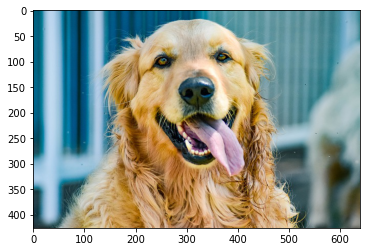

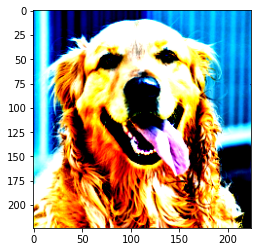

In [7]:
# 화상 읽기

image_file_path = './pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

# 원본 화상 표시
plt.imshow(img)
plt.show()

# 화상 전처리 및 처리 화상 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, .224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비 색상)으로 변환하고 0-1로 값을 제한하여 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.show()

## 학습된 VGG 모델로 화상 예측 

In [8]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class ILSVRCPredictor() :
    '''ILSVRC 데이터 모델 출력에서 라벨을 구함'''
    def __init__(self, class_index) :
        self.class_index= class_index
        
    def predict_max(self, out) :
        '''최대확률의 ILSVRC 라벨명을 가져온다'''
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name  

In [9]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('./pytorch_advanced/1_image_classification/data/imagenet_class_index.json', 'r'))

# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 입력 화상 읽기
image_file_path = './pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이][너비][RGB]

# 전처리 후 배치 크기 차원 추가
transform = BaseTransform(resize, mean, std) # 전처리 클래스
img_transformed = transform(img) # [3, 224, 224]
inputs = img_transformed.unsqueeze_(0) # [1, 3, 224, 224]

# 모델 입력 후 출력을 라벨로 변환
out = net(inputs) 
result = predictor.predict_max(out)

print(f'입력 화상의 예측 결과 : {result}')

입력 화상의 예측 결과 : golden_retriever


# Pytorch로 전이학습(딥러닝) 구현하기 
- 1. Dataset 클래스 (훈련데이터, 검증데이터, 테스트데이터의 Dataset) 작성 : 전처리 클래스 인스턴스를 할당하여 자동 전처리 적용
- 2. DataLoader 클래스(훈련데이터, 검증데이터, 테스트데이터의 DataLoader) : Dataset에서 데이터를 어떻게 가져올지 설정 --> 일반적으론 미니배치 학습    
- 3. 네트워크 모델 생성, 순전파 함수 정의
- 4. 오차 역전파법을 하기 위한 손실함수 정의
- 5. 네트워크 모델의 결합 파라미터를 학습시키기 위한 최적화 기법 설정 (모멘텀SGD 등)

In [10]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


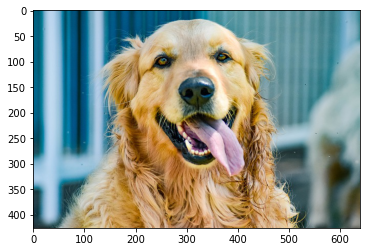

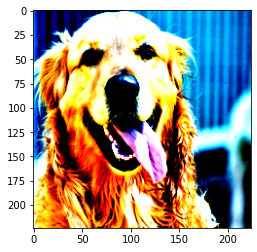

In [11]:
class ImageTransform() :
    '''전처리 클래스
    --> 화상 크기 리사이즈, 색상 표준화.
    --> 훈련 시 RandomResizedCorp 및 RandomHorizontalFlip으로 데이터 확장 '''
    
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop( resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train') :
        '''전처리 모드 지정'''
        return self.data_transform[phase](img)
    
    
# 훈련 시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀜
image_file_path = './pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0 , 1)
plt.imshow(img_transformed)
plt.show()

In [12]:
def make_datapath_list(phase='train') :
    rootpath = './pytorch_advanced/1_image_classification/data/hymenoptera_data/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path) :
        path_list.append(path)
        
    return path_list


train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

# train_list

./pytorch_advanced/1_image_classification/data/hymenoptera_data/train/**/*.jpg
./pytorch_advanced/1_image_classification/data/hymenoptera_data/val/**/*.jpg


In [53]:
# 개미와 벌의 화상에 대한 dataset 작성
class HymenoperaDataset(data.Dataset) :
    
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        '''화상 개수 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index) : 
        '''전처리한 화상의 텐서 형식 데이터와 라벨 획득'''
        
        # idx번째 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        # 전처리
        img_transformed = self.transform(img, self.phase)
        
        # 화상 라벨을 파일 이름에서 추출
        if self.phase == 'train' :
            label = img_path[70 : 74]
        elif self.phase == 'val' :
            label = img_path[68:72]
            
        # 라벨을 숫자로
        if label == 'ants' :
            label = 0
        elif label == 'bees' :
            label = 1
        else :
            print(label)
        return img_transformed, label

In [54]:
# 실행
train_dataset = HymenoperaDataset(file_list = train_list, transform = ImageTransform(size, mean, std), phase = 'train')

val_dataset = HymenoperaDataset(file_list = val_list, transform =ImageTransform(size, mean, std), phase = 'val')

# 동작 check
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


In [55]:
# 데이터 로더 작성

# mini batch
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
                        train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
                        val_dataset, batch_size=batch_size, shuffle=False)


# 사전형 변수에 정리
dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1])


In [56]:
# pretrained VGG-16 model load
# VGG-16 인스턴스 생성
use_pretrained= True
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층 출력 유닛을 개미와 벌 두개로 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

# 손실함수 설정
criterion = nn.CrossEntropyLoss()

## 최적화 기법 설정

# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

# 학습시킬 파라미터 명 
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 학습시킬 파라미터 외에 경사를 계산하지 않고 변하지 않도록 설정
for name, param in net.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else :
        param.requires_grad = False
        
# params to update 내용 확인
print('-' * 50)
print(params_to_update)

# 최적화 기법 사용
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

classifier.6.weight
classifier.6.bias
--------------------------------------------------
[Parameter containing:
tensor([[ 0.0104, -0.0070, -0.0036,  ..., -0.0130, -0.0115, -0.0102],
        [-0.0088,  0.0018, -0.0012,  ..., -0.0132,  0.0147, -0.0057]],
       requires_grad=True), Parameter containing:
tensor([ 0.0139, -0.0021], requires_grad=True)]


In [59]:
## 학습 및 검증 

def train_model(net , dataloaders_dict, criterion, optimizer, num_epochs) :
    # 에폭
    for epoch in range(num_epochs) : 
        print(f'Epoch {epoch + 1}/ {num_epochs}')
        print('*' * 30)
        
        # 에폭 별 학습 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # 훈련 모드
            else :
                net.eval() # 검증 모드
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            # 학습 하지 않을 시 검증성능 확인을 위해 epoch= 0의 훈련 생략
            if (epoch==0) and (phase == 'train') :
                continue
            # 데이터 로더로 미니 배치 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]) :
                
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train') :
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 손실 계산
                    _, preds = torch.max(outputs, 1) # 라벨 예측
                    
                    
                    # 훈련 시 오차 역전파
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()
                        
                    # 반복 결과 계산, 손실 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                # 에폭 당 손실과 정답률 표시
                epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
                    
                print(f'{phase} Loss {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
                    
        

In [60]:
# train_model 함수 실행
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs =num_epochs)

Epoch 1/ 2
******************************


 20%|██        | 1/5 [00:04<00:19,  4.80s/it]

val Loss 0.1934 Acc : 0.0458


 40%|████      | 2/5 [00:09<00:14,  4.84s/it]

val Loss 0.1762 Acc : 0.1307


 60%|██████    | 3/5 [00:14<00:09,  5.00s/it]

val Loss 0.1317 Acc : 0.2680


 80%|████████  | 4/5 [00:19<00:04,  4.97s/it]

val Loss 0.1088 Acc : 0.4510


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


val Loss 0.0828 Acc : 0.5882
Epoch 2/ 2
******************************


 12%|█▎        | 1/8 [00:05<00:36,  5.17s/it]

train Loss 0.0878 Acc : 0.0658


 25%|██▌       | 2/8 [00:10<00:30,  5.07s/it]

train Loss 0.0768 Acc : 0.1564


 38%|███▊      | 3/8 [00:15<00:25,  5.11s/it]

train Loss 0.1007 Acc : 0.2263


 50%|█████     | 4/8 [00:20<00:20,  5.04s/it]

train Loss 0.0787 Acc : 0.3086


 62%|██████▎   | 5/8 [00:25<00:15,  5.06s/it]

train Loss 0.0633 Acc : 0.4115


 75%|███████▌  | 6/8 [00:30<00:10,  5.06s/it]

train Loss 0.0409 Acc : 0.5309


 88%|████████▊ | 7/8 [00:35<00:05,  5.00s/it]

train Loss 0.0390 Acc : 0.6502


100%|██████████| 8/8 [00:38<00:00,  4.79s/it]


train Loss 0.0110 Acc : 0.7243


 20%|██        | 1/5 [00:04<00:19,  4.98s/it]

val Loss 0.0261 Acc : 0.2092


 40%|████      | 2/5 [00:09<00:14,  4.94s/it]

val Loss 0.0251 Acc : 0.4052


 60%|██████    | 3/5 [00:14<00:10,  5.00s/it]

val Loss 0.0477 Acc : 0.5948


 80%|████████  | 4/5 [00:19<00:04,  4.97s/it]

val Loss 0.0589 Acc : 0.7778


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]

val Loss 0.0647 Acc : 0.9281
